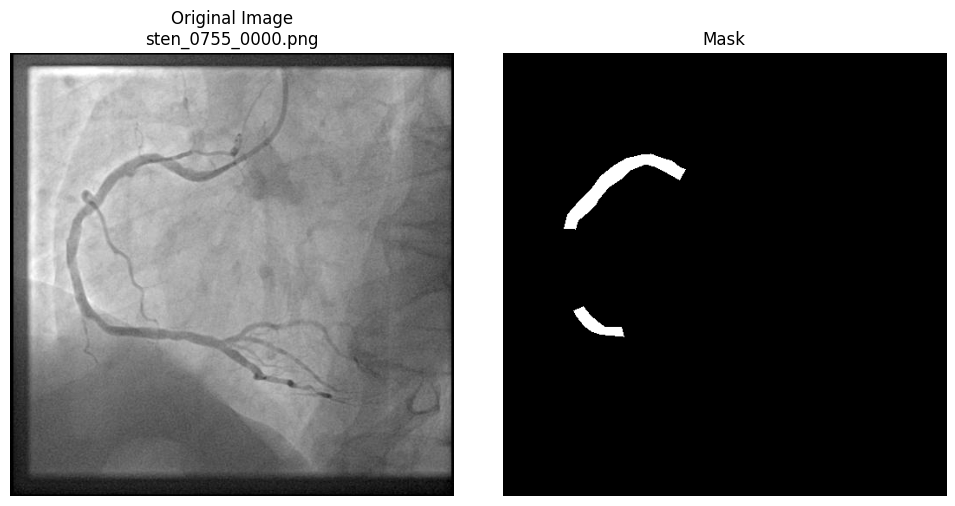

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Define paths
data_root = "../nnNet_training/Raw_data/Dataset_train_val"
image_dir = os.path.join(data_root, "imagesTr")
mask_dir = os.path.join(data_root, "labelsTr")

def load_random_image_and_mask():
    """Loads a random image and its corresponding mask."""
    image_files = [f for f in os.listdir(image_dir) if f.endswith(".png")]
    if not image_files:
        print("No images found.")
        return None, None, None
    
    random_image = random.choice(image_files)
    image_path = os.path.join(image_dir, random_image)
    mask_filename = random_image.replace("_0000.png", ".png")  # Ensure correct mapping
    mask_path = os.path.join(mask_dir, mask_filename)
    
    if not os.path.exists(mask_path):
        print(f"Mask not found for {random_image}")
        return None, None, None
    
    return Image.open(image_path), Image.open(mask_path), random_image

def visualize_image_and_mask():
    """Plots a random image and its corresponding mask."""
    image, mask, filename = load_random_image_and_mask()
    
    if image is None or mask is None:
        print("Could not load image and mask.")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image, cmap="gray" if image.mode == "L" else None)
    axes[0].set_title(f"Original Image\n{filename}")
    axes[0].axis("off")
    
    axes[1].imshow(mask, cmap="gray")
    axes[1].set_title("Mask")
    axes[1].axis("off")
    
    plt.tight_layout()
    plt.show()

# Run visualization
visualize_image_and_mask()